<a href="https://colab.research.google.com/github/yajuna/cerf/blob/master/finite_difference_for_acoustic_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consider the one dimensional acoustic wave equation

$$\frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}$$

with periodic boundary condition, on an interval of [0,3].

The discretization is

$$\frac{u(x,t+\Delta t)-2u(x,t)+u(x,t-\Delta t)}{(\Delta t)^2}=c^2\frac{u(x+\Delta x,t)-2u(x,t)+u(x-\Delta x,t)}{(\Delta x)^2}$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

from time import time

from IPython.display import clear_output

clear_output()

Define parameters:

the spatial domain is [0,3], time is [0,24], there are 400 points in space

We take the CLF number $\gamma=0.6$, and wave speed $c= 1$.

In [11]:
pi = np.pi

# Set number of data points
N = 263
Nt = 600

# Set time and space domain
tmin = 0.

xmin = 0.
xmax = 3.

# wave speed; CFL number for stability
c = 1
gamma = 0.6

# Set grid size and time step
xgrid = np.linspace(xmin, xmax, N)
dx = (xmax - xmin)/N
dt = gamma * dx # gamma = dt / dx

### Define the true solution to the wave equation
We use the function $u_{true}(x,t)=\phi(x,t)=\sin(2\pi\xi(x-ct))e^{-\beta(x-ct-0.5)^2}$ as the analytical solution to the wave equation.

We would like to see 8 points per wavelength, so $\xi\Delta x = \frac{2\pi}{8}$.

Here we take $\beta = 16$, $2\pi\xi = 125.7$.

In [12]:
beta = 16
pi2xi = 125.7
def utrue(x,t):
  xat = (x - c * t) % 3
  return np.sin(pi2xi * xat) * np.exp(-beta * (xat - 0.5)**2)

Plot initial conditions, numerically implemented specifying $u(x,0)$ and $u(x,\Delta t)$

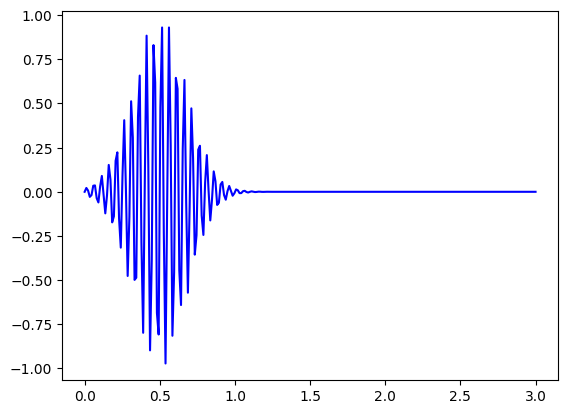

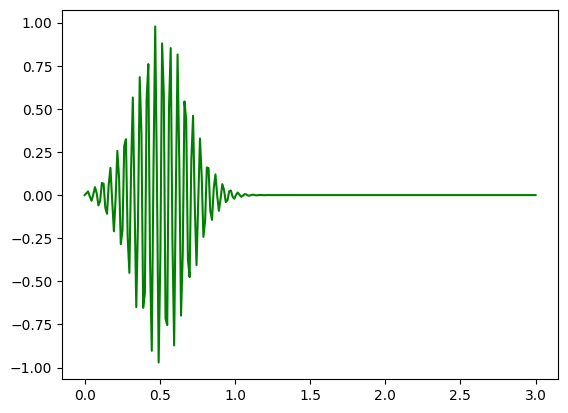

In [13]:
# define initial conditions
u_previous = utrue(xgrid, tmin)
u_current = utrue(xgrid, tmin + dt)
plt.figure(1)
plt.plot(xgrid, u_previous, 'b')
plt.figure(2)
plt.plot(xgrid, u_current, 'g')

We implement a simple for loop to show the iterations

Let $U^1$ denote the solution at next time step; $U$ the solution at the current time step, and $U^{-1}$ denote the solution at previous time step; $U_{-1}$ denotes the solution on the left, and $U_{1}$ denotes the solution on the right.

$U^1 = (c\gamma)^2U_{-1}+2(1-(c\gamma)^2)U+(c\gamma)^2U_1 - U^{-1}$

In [14]:
# # define solution of row Nt, each column of N points
# solution = np.zeros((Nt, N))
# # print("first column of solution", solution[:,0].shape)
u_solution = [u_previous, u_current]
print(len(u_solution), u_solution[0].shape)

2 (263,)


In [17]:
a = (c * gamma)**2
b = 2*(1 - a)
coeff = [a * np.ones(N-1), b * np.ones(N), a * np.ones(N-1)]
offset = [-1,0,1]
A = diags(coeff, offset).toarray()
A[0, -1] = a
A[-1,0] = a

In [18]:
print(A)

[[1.28 0.36 0.   ... 0.   0.   0.36]
 [0.36 1.28 0.36 ... 0.   0.   0.  ]
 [0.   0.36 1.28 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.28 0.36 0.  ]
 [0.   0.   0.   ... 0.36 1.28 0.36]
 [0.36 0.   0.   ... 0.   0.36 1.28]]


We vectorize the algorithm and write $U^1=AU-U^{-1}$. Here $A$ is the coefficient matrix defined above.

In [21]:
for time in range(2, Nt):
  U1 = A.dot(u_solution[time-1]) - u_solution[time-2]
  u_solution.append(U1)

In [22]:
print(len(u_solution))

600


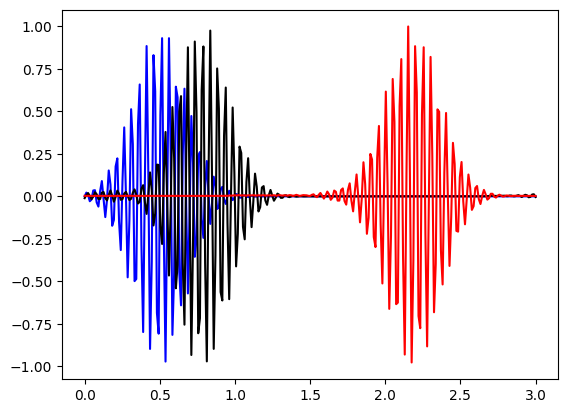

In [23]:
plt.figure(3)
plt.plot(xgrid, u_solution[0], 'b', xgrid, u_solution[50], 'k',xgrid, u_solution[300], 'r' )